# Community Detection Algorithms

This notebook showcases all the community detection algorithms applied to the SBB train network.
It runs each technique, shows some statistics about the results, and plots the graph with communities.

All our community techniques are performed on the largest connected component.
Louvain is also applied to the entire graph for this demo as well.
The performance evaluation is available in `community_detection_evaluation.ipynb`.

The graph is loaded from the `data/sbb.edgelist`; Neo4j is optional. The edgelist is provided in the respository.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
G = nx.read_edgelist("data/sbb.edgelist", delimiter=";", create_using=nx.Graph)

print(f"number of nodes: {len(G.nodes)}")
print(f"number of edges: {len(G.edges)}")

# we apply the techniques on the largest connected components
connected_comp = nx.connected_components(G)
max_connected_comp = max(connected_comp)
print("Number of nodes in largest connected component:", len(max_connected_comp))

G_lcc = G.subgraph(max_connected_comp)

number of nodes: 3152
number of edges: 4678
Number of nodes in largest connected component: 3017


# 1. Community Detection


In [3]:
import random

def community_stats(communities, algorithm_name):
    comms_len = [len(c) for c in communities]
    print(f"{algorithm_name}: number of communities: {len(communities)}")
    print(f"{algorithm_name}: size of each community: {comms_len}")


def plot_communities(G, communities, algorithm_name):
    getcolors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
    colors = getcolors(len(communities))

    plt.figure(figsize=(12, 9))    
    pos = nx.spring_layout(G, seed=42)     
    for i, c in enumerate(communities):
        nx.draw_networkx_nodes(     
            G, pos=pos, nodelist=c, node_color=colors[i], node_size=10, alpha=0.75        
        )            

    nx.draw_networkx_edges(G, pos=pos, width=0.20, alpha=0.33)
    plt.title(f"{algorithm_name} Community Detection")
    plt.show()

## 1.1 Louvain

### 1.1.1 Louvain on the Entire Graph

In [4]:
louvain = nx.community.louvain_communities(G, seed=42)

community_stats(louvain, "Louvain (Full Graph)")

Louvain (Full Graph): number of communities: 57
Louvain (Full Graph): size of each community: [98, 93, 131, 47, 25, 20, 26, 222, 15, 13, 117, 13, 30, 32, 12, 19, 137, 55, 83, 45, 18, 24, 99, 156, 51, 18, 20, 43, 12, 50, 3, 98, 27, 24, 74, 103, 38, 128, 20, 29, 17, 9, 202, 2, 212, 50, 50, 94, 20, 20, 79, 29, 64, 12, 7, 10, 7]


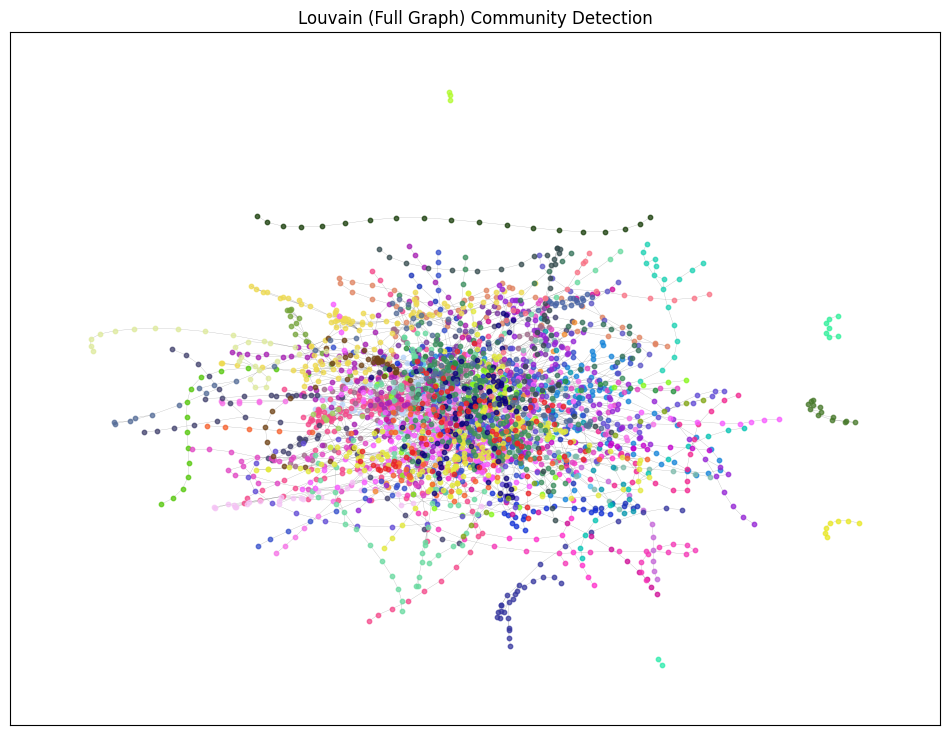

In [5]:
plot_communities(G, louvain, "Louvain (Full Graph)")

### 1.1.2 Louvain with Largest Connected Components

In [6]:
louvain = nx.community.louvain_communities(G_lcc, seed=42)

community_stats(louvain, "Louvain")       

Louvain: number of communities: 45
Louvain: size of each community: [93, 27, 18, 116, 116, 15, 13, 151, 79, 61, 121, 85, 134, 104, 45, 156, 135, 15, 23, 32, 51, 18, 20, 135, 43, 27, 25, 24, 19, 38, 113, 50, 72, 17, 202, 28, 43, 20, 56, 50, 29, 117, 20, 50, 211]


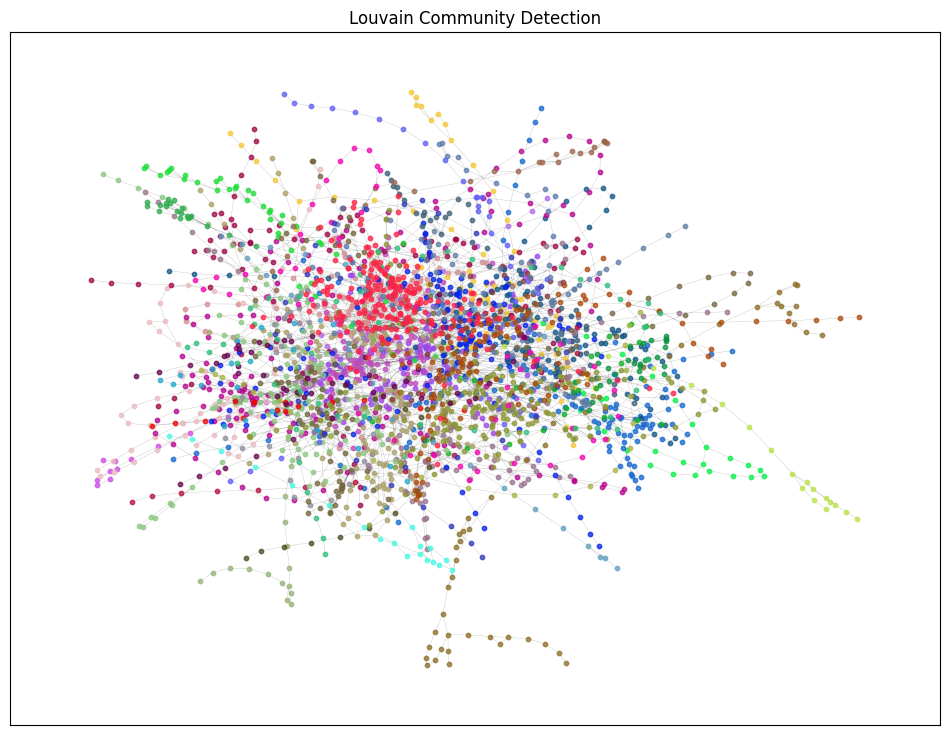

In [7]:
plot_communities(G_lcc, louvain, "Louvain")

### 1.1.3 Louvain: Our Implementation

In [8]:
from louvain import louvain_implementation

G_lcc = nx.Graph(G_lcc)
louvain_imp = louvain_implementation(G_lcc)

community_stats(louvain_imp, "Louvain Implementation")

Louvain Implementation: number of communities: 65
Louvain Implementation: size of each community: [84, 16, 7, 8, 77, 18, 114, 88, 3, 89, 13, 12, 104, 26, 9, 44, 6, 18, 46, 21, 69, 5, 10, 32, 7, 59, 40, 34, 133, 142, 21, 107, 44, 30, 21, 18, 20, 117, 23, 27, 24, 40, 25, 19, 38, 6, 16, 16, 212, 23, 4, 69, 43, 172, 3, 18, 126, 102, 50, 34, 32, 11, 98, 29, 45]


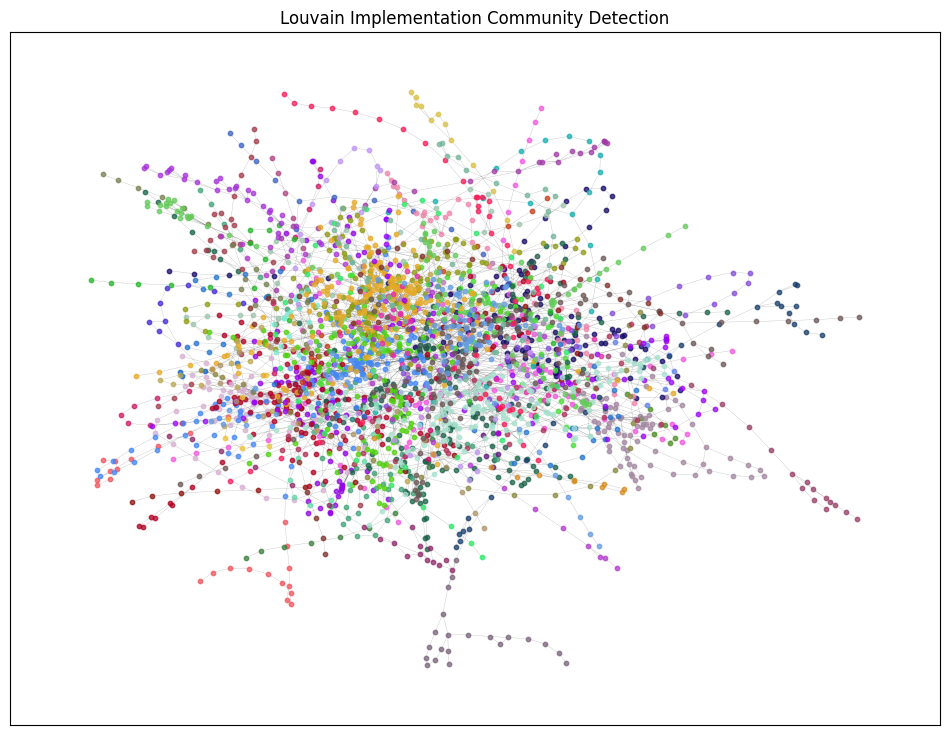

In [9]:
plot_communities(G_lcc, louvain_imp, "Louvain Implementation")

## 1.2 Girvan-Newman

In [ ]:
import time

def girvan_newman(G, time_threshold=1):
    gn_communities = nx.community.girvan_newman(G)

    iter_count = 0
    coms = []

    # Apply Girvan-Newman iteratively for > time_threshold hour
    timeout = time.time() + 60 * time_threshold
    while True:
        if time.time() > timeout:
            break
        
        iter_count += 1
        coms = next(gn_communities, 'end')

    print(f'number of iterations: {iter_count}')
    return coms


gn = girvan_newman(G_lcc, time_threshold=8)

In [ ]:
community_stats(gn, "Girvan Newman")

In [ ]:
plot_communities(G_lcc, gn, "Girvan Newman")

## 1.3 Leiden

In [10]:
import leidenalg as la
import igraph as ig

def leiden_communities(G):
    graph = ig.Graph.from_networkx(G, vertex_attr_hashable='name')

    partition = list(la.find_partition(graph, la.ModularityVertexPartition))
    # convert back the node ids to node names
    idx2name = {idx: name for idx, name in enumerate(list(G.nodes))}
    communities = []
    for comm in partition:
        communities.append({idx2name[n] for n in comm})
        
    return communities

In [11]:
leiden = leiden_communities(G_lcc)

community_stats(leiden, "Leiden")

Leiden: number of communities: 46
Leiden: size of each community: [168, 148, 142, 137, 136, 126, 121, 119, 111, 110, 105, 99, 89, 89, 85, 83, 76, 75, 74, 65, 63, 56, 54, 51, 50, 49, 47, 47, 44, 44, 38, 36, 29, 27, 25, 24, 20, 20, 20, 19, 18, 18, 17, 15, 15, 13]


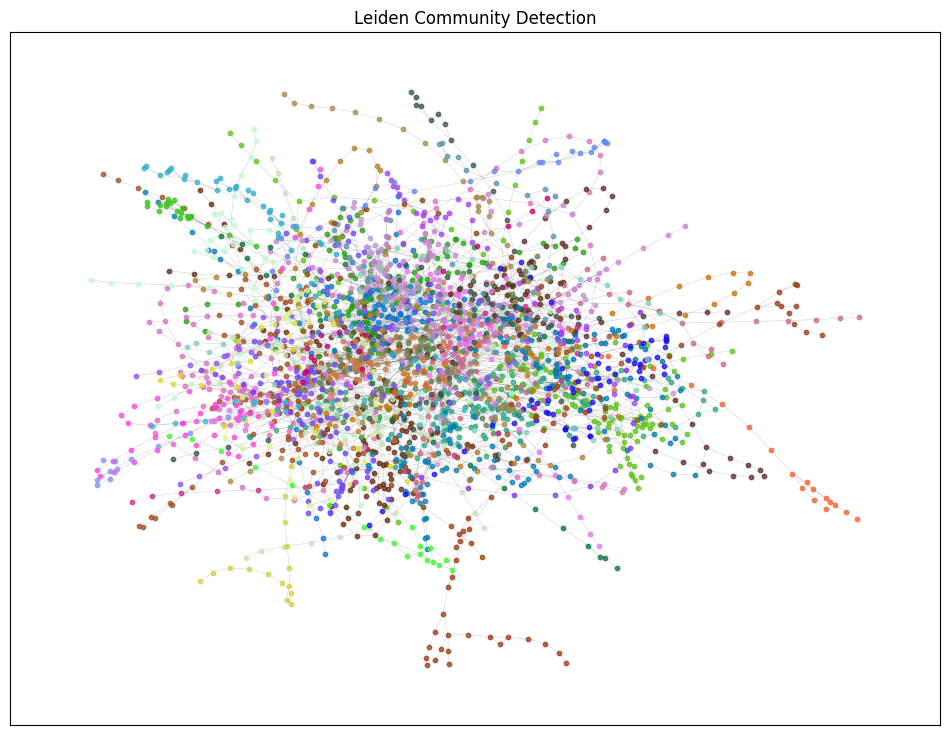

In [12]:
plot_communities(G_lcc, leiden, "Leiden")